# Messy modelling: overfitting, cross-validation, and the bias-variance trade-off

## Introduction

In this post you will get to grips with perhaps the most essential concept in machine learning: the **bias-variance trade-off**. The main idea here is that you want to create models that are as good at prediction as possible but that are still applicable when looking at new data (i.e. are generalizable).  The danger is that you can easily create models that **overfit** to the local noise in the data, which isn't too helpful and leads to poor generalizability since the noise is random and different in each dataset. Essentially, you want to create models that capture only the useful components of the dataset. Models that generalize very well but are too inflexible to generate good predictions (they **underfit** the data) are the other extreme we want to avoid. 

We discuss and demonstrate these concepts using the k-nearest neighbours algorithm, which has a simple parameter k which can be varied to cleanly demonstrate these ideas of underfitting, overfitting and generalization. Together, this bundle of concepts related to the balance between underfitting and overfitting is called the bias-variance trade-off. Here is a table summarizing these different aspects of models.

![Bias variance trade-off table](https://github.com/adam-p/markdown-here/raw/master/src/common/images/icon48.png "Bias variance trade-off summary table")

You will encounter these concepts in the next few blog posts in this series, which will cover model optimization, random forests, Naive Bayes, logistic regression and combining different models into an ensembled meta-model. 

## Generating the dataset

We start off by building an artificial dataset with which we can explore the concepts of the bias-variance trade-off. We do this with the `make_classification()` function from the `sklearn.datasets` package. Specifically, we will generate a relatively simple binary classification problem. To make it a bit more interesting you will add some random noise to the dataset, which should make it more difficult to classify the observations.

In [24]:
# Generate the dataset
# e.g. make_moons creates crescent shaped data
# make_classification generates linearly-separable data
from sklearn.datasets import make_moons, make_classification

X, y = make_moons(
    n_samples=500,  # the number of observations
    random_state=1,
    noise=0.3 #0.3
)

print(X[:10,])
print(y[:10])

[[ 0.50316464  0.11135559]
 [ 1.06597837 -0.63035547]
 [ 0.95663377  0.58199637]
 [ 0.33961202  0.40713937]
 [ 2.17952333 -0.08488181]
 [ 2.00520942  0.7817976 ]
 [ 0.12531776 -0.14925731]
 [ 1.06990641  0.36447753]
 [-0.76391099 -0.6136396 ]
 [ 0.55678871  0.8810501 ]]
[1 1 0 0 1 1 1 0 0 0]


Next up, let's split the dataset into a training and test set. The training set will be used to develop and tune our predictive models. The test will be completely left alone until the very end, at which point you'll run your finished models on it. Having a test set will allow you to get a good estimate of how well our models would perform out in the wild on unseen data.

In [25]:
from sklearn.cross_validation import train_test_split

# Split into training and test sets
XTrain, XTest, yTrain, yTest = train_test_split(X, y, random_state=1)

We are first going to try to predict classes with a k Nearest Neighbor (kNN) classifier. Chapter 2 of the [Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Sixth%20Printing.pdf) book provides a truly excellent introduction to theory behind kNN.

## Introducing kNN

The higher the number of neighbours that we consider when making a descision about the class of an unknown datapoint, the more constrained it is. In other words a high number for `k` give rise to a "rigid" behaviour of the model. On the other hand, if the value for `k` is low, the the model is very flexible as only a few neighbours are taken into account when making a descision and the outcome is much more dependent of the local disposition of the data.

As we have introduced before, overfitting readily occurs when a model is too flexible and learns the local properties of the data, which in case noise is present (which is always the case) is counter productive. This is the case as the model will not generalise to new data. On the other hand a too rigid model will not be able to learn particular patterns in the data and will gloss over them. Such a model would be considered to be underfitting.

All algorithms can be considered to have a certain degree of flexibility and this is not specific to kNN. Therefore the priciple of finding the sweet spot of flexibility that describes that pattern of the data well but is still generalisatble to new data is applies to all learning algorithms. A lot of work has been done in playing with the flexibility of models, for instance regularisation plays with this consideration.

Model complexity and model flexibility are often terms used to describe how ...

For more information on how the k Nearest Neighbors algorithm works you could have a look at this previous post that teaches you [how to implement it from scratch in python](http://blog.cambridgecoding.com/2016/01/16/machine-learning-under-the-hood-writing-your-own-k-nearest-neighbour-algorithm/).

In [26]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [27]:
knn3 = KNeighborsClassifier(n_neighbors = 3)
knn3.fit(XTrain, yTrain)
yPredK3 = knn3.predict(XTest)
print "Overall Error:", 1 - round(metrics.accuracy_score(yTest, yPredK3), 2)

Overall Error: 0.12


The code is simplified version of the [scikit-learn example](http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html).

In [28]:
import numpy as np

def detect_plot_dimension(X, h=0.02, b=0.05):
    '''
    Function to detect the plot dimensions (considering Training and Test data)
    Parameters: X - the dataset
                h - the granularity of the visual display of the boundary
                b - the space buffer at the extreme values
    '''
    x_min, x_max = X[:, 0].min() - b, X[:, 0].max() + b
    y_min, y_max = X[:, 1].min() - b, X[:, 1].max() + b
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    dimension = xx, yy
    return dimension
    

def detect_decision_boundary(dimension, model):
    '''
    Function to detect the decision boundaries
    Parameters: dimension - the plot dimension as calculated by detect_plot_dimension()
                model     - the model used for the prediction
    '''
    xx, yy = dimension  # unpack the dimensions
    boundary = model.predict(np.c_[xx.ravel(), yy.ravel()])
    boundary = boundary.reshape(xx.shape)  # Put the result into a color plot
    return boundary


def plot_decision_boundary(panel, dimension, boundary, colors=['#DADDED', '#FBD8D8']):
    '''
    Function to plot decision boundary
    Parameters: panel     - the plotting element to modify
                dimension - the plot dimension as calculated by detect_plot_dimension()
                boundary  - boundary tuple as calculated by detect_decision_boundary()
                colors    - the colors to use for the boundary surface
    '''
    xx, yy = dimension  # unpack the dimensions
    panel.contourf(xx, yy, boundary, cmap=ListedColormap(colors), alpha=1)
    panel.contour(xx, yy, boundary, colors="g", alpha=1, linewidths=0.5)  # the decision boundary in green


def plot_dataset(panel, X, y, colors=["#EE3D34", "#4458A7"], markers=["x", "o"]):
    '''
    Function to plot the observations of of a dataset with their class assigment
    Parameters: panel   - the plotting element to modify
                X       - the predictor dataset
                y       - the classification
                colors  - the color of the two classes
                markers - the markers to represent the two classes
    '''
    
    panel.scatter(X[y == 1, 0], X[y == 1, 1], color=colors[0], marker=markers[0])#, s=6)
    panel.scatter(X[y == 0, 0], X[y == 0, 1], color=colors[1], marker=markers[1])#, s=6)


def calculate_prediction_error(model, X, y):
    '''
    Function to estimate the prediction error
    Parameters: model - the model used for the prediction
                X     - the predictor dataset
                y     - the classification
    '''
    yPred = model.predict(X)
    score = 1 - round(metrics.accuracy_score(y, yPred), 2)
    return score


def plot_prediction_error(panel, dimension, score, b=.3):
    '''
    Function to plot the prediction error in the bottom right of the plot
    Parameters: panel     - the plotting element to modify
                dimension - the plot dimension as calculated by detect_plot_dimension()
                score     - the prediciton error as calculated by calcualte_prediciton_error()
                b         - the offset of the text from the bottom right
    '''
    xx, yy = dimension  # unpack the dimensions
    panel.text(xx.max() - b, yy.min() + b, ('%.2f' % score).lstrip('0'), size=15, horizontalalignment='right')

In [40]:
def explore_fitting_boundaries(model, n_neighbors, datasets, width): #direction="vertical"):
    '''
    Function to produce a grid of k number of neighbours (x-axis) against different datasets
    tested (y-axis)
    Note: Only supplying one dataset works
    Parameters: model       - the model to be tested (assumes KNeighborsClassifier())
                n_neighbors - a list of the the number k to be tested
                datasets    - a dictionary of lists with each a training and a test set
                figsize     - the dimension of the plot
                # direction   - should the comparable plots be arranged verically or horizontally
    '''
    
    # determine the height of the plot given the aspect ration of each panel should be equal
    height = float(width)/len(n_neighbors) * len(datasets.keys())

    nrows = len(datasets.keys())
    ncols = len(n_neighbors)
    
    # set up the plot
    figure, axes = plt.subplots(
        nrows,
        ncols,
        figsize=(width, height),
        sharex=True,
        sharey=True
    )

    dimension = detect_plot_dimension(X, h=0.02)  # the dimension each subplot based on the data

    i = 0
    for n in n_neighbors:
        model.n_neighbors = n
        model.fit(datasets["Training Set"][0], datasets["Training Set"][1])
        boundary = detect_decision_boundary(dimension, model)
        j = 0
        for d in datasets.keys():
            try:
                panel = axes[j, i]
            except (TypeError, IndexError):
                if (nrows * ncols) == 1:
                    panel = axes
                elif nrows == 1:  # if we only have one dataset
                    panel = axes[i]
                elif ncols == 1:  # if we only try one number of neighbors
                    panel = axes[j]
            plot_decision_boundary(panel, dimension, boundary)  # plot the decision boundary
            plot_dataset(panel, X=datasets[d][0], y=datasets[d][1])  # plot the observations
            score = calculate_prediction_error(model, X=datasets[d][0], y=datasets[d][1])
            plot_prediction_error(panel, dimension, score, b=0.2)  # plot the score
            # make compacted layout
            panel.set_frame_on(False)
            panel.set_xticks([])
            panel.set_yticks([])
            # format the axis labels
            if i == 0:
                panel.set_ylabel(d)
            if j == 0:
                panel.set_title('k={}'.format(n))
            j += 1
        i += 1    

    plt.subplots_adjust(hspace=0, wspace=0)  # make compacted layout

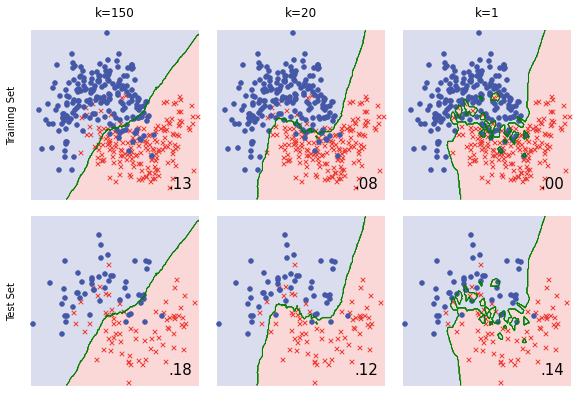

In [41]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

%matplotlib inline

model = KNeighborsClassifier()
n_neighbors = [200, 100, 20, 5, 1]
datasets = {
    "Training Set": [XTrain, yTrain],
    "Test Set": [XTest, yTest]
}
width = 15

# # explore_fitting_boundaries(model, n_neighbors, datasets, width)
explore_fitting_boundaries(model=model, n_neighbors=[150, 20, 1], datasets=datasets, width=10)

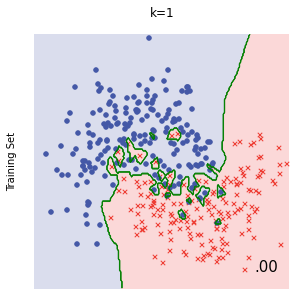

In [42]:
explore_fitting_boundaries(model=model, n_neighbors=[1], datasets={"Training Set": [XTrain, yTrain]}, width=5)

In [43]:
knn99 = KNeighborsClassifier(n_neighbors = 99)
knn99.fit(XTrain, yTrain)
yPredK99 = knn99.predict(XTest)
print "Overall Error:", 1 - round(metrics.accuracy_score(yTest, yPredK99), 2)

Overall Error: 0.14


## The Challenge of getting the right flexibility

Let's examine the shape of the dataset (the number of rows and columns), the types of features it contains, and some summary statistics for each feature.

An overall accuracy of 0.95 is very good for a start, but keep in mind that this is a heavily idealized dataset. Next up, we are going to learn how to pick the best parameters for the random forest algorithm (as well as for an SVM and logistic regression classifier) in order to get better models with (hopefully!) improved accuracy.

## The perils of overfitting

In order to build the best possible model that does a good job at describing the underlying trends in a dataset, we need to pick the right HP values. In the following example, we will introduce different strategies of searching for the set of HPs that define the best model, but we will first need to make a slight detour to explain how to avoid a major pitfall when it comes to tuning models - **overfitting**.

The hallmark of overfitting is good training performance and bad testing performance. 

As we mentioned above, HPs are not optimised while a learning algorithm is learning. Hence, we need other strategies to optimise them. The most basic way would just to test different possible values for the HPs and see how the model performs. In a random forest, [some hyperparameters](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) we can optimise are `n_estimators` and `max_features`. `n_estimators` controls the number of trees in the forest - the more the better, but more trees comes at the expense of longer training time. `max_features` controls the size of the random selection of features the algorithm is allowed to consider when splitting a node. 

Let's try out some HP values.

We can manually write a small loop to test out how well the different combinations of these fare (later, we'll find out better ways to do this): 

Looks like the higher value of `n_estimators` and the lower value of `max_features` did better. However, manually searching for the best HPs in this way is not efficient and could potentially lead to models that perform well on the training data, but do not generalise well to a new dataset, which is what we are actually interested in. This phenomenon of building models that do not generalise well, or that are fitting too closely to the training dataset, is called **overfitting**. This is a very important concept in machine learning and it is very much worth to get a better understanding of what it is. Let's briefly discuss the **bias-variance tradeoff**.

## The bias-variance trade-off

When we train machine learning algorithms on a dataset, what we are really interested in is how our model will perform on an independent data set. It is not enough to predict whether emails in our training set are spam - how well would the model fare when predicting if a completely new, previously unseen datapoint is spam or not? 

This is the idea behind splitting your dataset into a **training set** (on which models can be trained) and a **test set** (which is held out until the very end of your analysis, and provides an accurate measure of model performance). Essentially, we are only interested in building models that are **generalizable** - getting 100% accuracy on the training set is not impressive, and is simply an indicator of **overfitting**. Overfitting is the situation in which we have fitted our model too closely to the data, and have tuned to the noise instead of just to the signal.

In fact, this concept of wanting to fit algorithms to the training data well, but not so tightly that the model doesn't generalize, is a pervasive problem in machine learning. A common term for this balancing act is **the bias-variance trade-off**. [Here](http://scott.fortmann-roe.com/docs/BiasVariance.html) is a nice introductory article on the topic that goes into more depth.

Have a look at how underfitting (high bias, low variance), properly fitting, and overfitting (low bias, high variance) models fare on the training compared to the test sets.


![The bias variance tradeoff.](./over_underfitting.png)

"Bias" and "variance" have got to be some of the least helpful terms in machine learning. One way to think of them is: a model that underfits (e.g. the straight line) is quite a bit wrong - it models the underlying generative process of the data as something too simple, and this is highly biased away from the truth. But, the straight line fit is not going to change very much across different datasets. The opposite trend applies to overfitted models.

Hence, we never try to optimize the model's perfomance on the training data because it is a misguided and fruitless endeavour. But wait, didn't we also say that the test set is not meant to be touched until we are completely done training our model? How are we meant to optimize our hyperparameters then? 

## k-fold cross validation

Enter **k-fold cross-validation**, which is a handy technique for measuring a model's performance using *only* the training set. k-fold CV is a general method, and is not specific to hyperparameter optimization, but is very useful for that purpose. Say that we want to do e.g. 10-fold cross-validation. The process is as follows: we randomly partition the training set into 10 equal sections. Then, we train an algorithm on 9/10ths (i.e. 9 out of the 10 sections) of that training set. We then evaluate its performance on the remaining 1 section. This gives us some measure of the model's performance (e.g. overall accuracy). We then train the algorithm on a *different* 9/10ths of the training set, and evaluate on the other (different from before) remaining 1 section. We continue the process 10 times, get 10 different measures of model performance, and average these values to get an overall measure of performance. Of course, we could have chosen some number other than 10. To keep on with the example, the process behind 10-fold CV looks like this:

![Diagram showing the steps behind 10-fold cross-validation.](./cv.png "10-fold CV")

We can use k-fold cross validation to optimize HPs. Say we are deciding whether to use 1,3 or 5 nearest-neighbours in our nearest-neighbours classifier. We can start by setting the `n_neighbours` HP in our classifier object to 1, running 10-fold CV, and getting a measurement of the model's performance. Repeating the process with the other HP values will lead to different levels of performance, and we can simply choose the `n_neighbours` value that worked best.

In the context of HP optimization, we perform k-fold cross validation together with **grid search** or **randomized search** to get a more robust estimate of the model performance associated with specific HP values. 

In [44]:
from sklearn.cross_validation import train_test_split, cross_val_score

knn = KNeighborsClassifier()

# the range of number of neighbours we want to test
n_neighbors = np.arange(1, 141, 2)

# here we store the results of each model
train_scores = list()
test_scores = list()
cv_scores = list()

for n in n_neighbors:
    knn.n_neighbors = n
    knn.fit(XTrain, yTrain)
    train_scores.append(1 - metrics.accuracy_score(yTrain, knn.predict(XTrain)))  # this will over-estimate the accuracy
    test_scores.append(1 - metrics.accuracy_score(yTest, knn.predict(XTest)))
    cv_scores.append(1 - cross_val_score(knn, XTrain, yTrain, cv = 5).mean())  # we take the mean of the CV scores

In [45]:
print('The best choice for Train would be {}, or the Test {} and with CV {}'.format(
        n_neighbors[train_scores == min(train_scores)],
        n_neighbors[test_scores == min(test_scores)],
        n_neighbors[cv_scores == min(cv_scores)]        
    )
)

The best choice for Train would be [1], or the Test [45 47 49 55 57 59 61 63 65 67 75 77 79] and with CV [15]


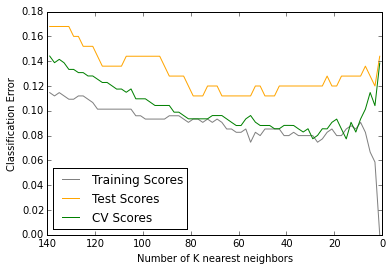

In [46]:
plt.plot(n_neighbors, train_scores, c = "grey", label = "Training Scores")
plt.plot(n_neighbors, test_scores, c = "orange", label = "Test Scores")
plt.plot(n_neighbors, cv_scores, c = "green", label = "CV Scores")
plt.xlabel('Number of K nearest neighbors')
plt.ylabel('Classification Error')
plt.gca().invert_xaxis()
plt.legend(loc = "lower left")
plt.show()

## Overfitting means modelling the noise 

Overfitting just means that we start modelling the noise. The noise is something that is very particular to that one sample of the data, which does not generalize to other datasets, and that is why modelling the noise does not make us better at modelling the underlying phenomenon we are interested in. However, it is not necessarily bad to use k=1 - we could get away with using this setting if it does not lead to us capturing the noise. However, in the real world, data is messy, so you are always in danger of overfitting to the noise. Stay on your toes.

We can explore how the modelling would look if there was little noise in the data:

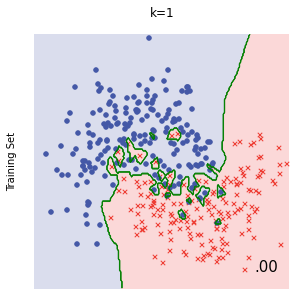

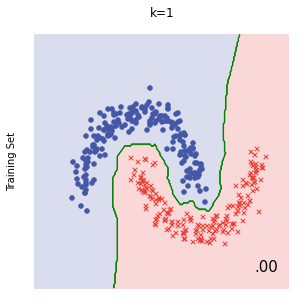

In [47]:
# Let's ramp up the noise in the dataset
X_no_noise, y_no_noise = make_moons(
    n_samples=500,  # the number of observations
    random_state=1,
    noise=0.1
)

# Split into training and test sets
XTrain_no_noise, XTest_no_noise, yTrain_no_noise, yTest_no_noise = train_test_split(X_no_noise, y_no_noise, random_state=1)

model = KNeighborsClassifier()

explore_fitting_boundaries(model=model, n_neighbors=[1], datasets={"Training Set": [XTrain, yTrain]}, width=5)
explore_fitting_boundaries(model=model, n_neighbors=[1], datasets={"Training Set": [XTrain_no_noise, yTrain_no_noise]}, width=5)

## Conclusion

In this post, we started with the motivation for tuning machine learning algorithms (i.e. nicer, bigger numbers in your models' performance reports!). We used different methods of searching over hyperparameter space, and evaluated candidate models at different points using k-fold cross validation. Tuned models were then run on the test set. Note that the concepts of training/test sets, cross-validation, and overfitting extend beyond the topic of tuning hyperparameters, though it is a nice application to demonstrate these ideas.

In this post, we tried to maximize the accuracy of our models, but there are problems for which you might want to maximize something else, like the model's specificity or the sensitivity. For example, if we were doing medical diagnostics and trying to detect a deadly illness, it would be very bad to accidentally label a sick person as healthy (this would be called a "false negative" in the lingo). Maybe it's not so bad if we misclassify healthy people as sick people ("false positive"), since in the worst case we would just annoy people by having them retake the diagnostic test. Hence, we might want our diagnostic model to be weighted towards optimizing sensitivity. [Here](http://www.ncbi.nlm.nih.gov/pmc/articles/PMC2636062/) is a good introduction to sensitivity and specificity which continues with the example of diagnostic tests.

Arguably, in spam detection, it is worse to misclassify real email as spam (false positive) than to let a few spam emails pass through your filter (false negative) and show up in people's mailboxes. In this case, we might aim to maximize specificity. Of course, we cannot be so focused on improving the specificity of our classifier that we completely bomb our sensitivity. There is a natural trade-off between these quantities (see [this primer on ROC curves](http://www.uphs.upenn.edu/radiology/education/resources/documents/receiver-operator-characteristic-analysis-primer.pdf)), and part of our job as statistical modellers is to practice the dark art of deciding where to draw the line.

Sometimes there is no tuning to be done. For example, a Naive Bayes (NB) classifier just operates by calculating conditional probabilities, and there is no real hyperparameter optimization stage. NB is actually a very interesting algorithm that is famous for classifying text documents (and the `spam` dataset in particular), so if you have time, check out a great overview and Python implementation [here]((https://bionicspirit.com/blog/2012/02/09/howto-build-naive-bayes-classifier.html)). It's a "naive" classifier because it rests on the assumption that the features in your dataset are independent, which is often not strictly true. In our spam dataset, you can image that the occurence of the strings "win", "money", and "!!!" is probably not independent. Despite this, NB often still does a decent job at classification tasks. 

In our next post, we will take these different tuned models and build them up into an ensemble model to increase our predictive performance even more. Stay... tuned! *Cue groans*.